In [1]:
import numpy as np
import torch 
import torch.nn as nn
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")



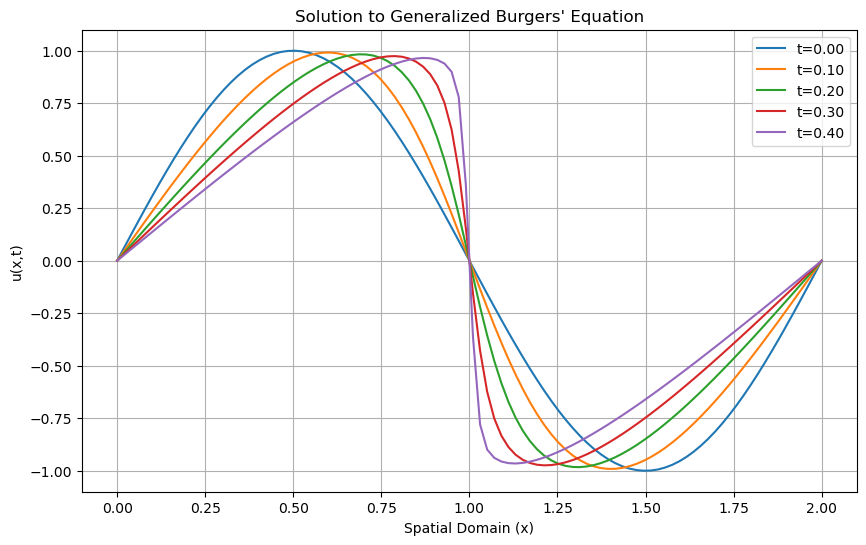

In [2]:
import numpy as np
import plotly.graph_objects as go

class BurgersEquation:
    def __init__(self, nu, L, T, Nx, Nt):
        self.nu = nu  # Viscosity
        self.L = L    # Length of the domain
        self.T = T    # Total time
        self.Nx = Nx  # Number of spatial points
        self.Nt = Nt  # Number of time steps
        
        self.dx = L / (Nx - 1)
        self.dt = T / Nt
        self.x = np.linspace(0, L, Nx)
        self.t = np.linspace(0, T, Nt)
        self.u = np.zeros((Nt, Nx))
        self.initial_condition()

    def initial_condition(self):
        """Set initial condition for the simulation."""
        self.u[0] = np.sin(np.pi * self.x)  

    def solve(self):
        """Solve the Burgers' equation using finite difference method."""
        for n in range(0, self.Nt - 1):
            for i in range(1, self.Nx - 1):
                self.u[n + 1, i] = (self.u[n, i] -
                                    self.u[n, i] * self.dt / (2 * self.dx) * (self.u[n, i + 1] - self.u[n, i - 1]) +
                                    self.nu * self.dt / (self.dx ** 2) * (self.u[n, i + 1] - 2 * self.u[n, i] + self.u[n, i - 1]))

    def plot_solution(self):
        """Plot the solution over time."""
        plt.figure(figsize=(10, 6))
        for n in range(0, self.Nt, int(self.Nt / 5)):  # Plot every fifth time step
            plt.plot(self.x, self.u[n], label=f't={n*self.dt:.2f}')
        
        plt.title('Solution to Generalized Burgers\' Equation')
        plt.xlabel('Spatial Domain (x)')
        plt.ylabel('u(x,t)')
        plt.legend()
        plt.grid()
        plt.show()

# Example usage
nu = 0.01   # Viscosity
L = 2.0     # Length of domain
T = 0.5     # Total time
Nx = 100    # Number of spatial points
Nt = 200    # Number of time steps

burgers_eq = BurgersEquation(nu, L, T, Nx, Nt)
burgers_eq.solve()
burgers_eq.plot_solution()

### Burger Equation using PINN

In [3]:
class BurgerEquationNN(nn.Module):
    def __init__(self):
        super(BurgerEquationNN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(2, 20),
            nn.Tanh(),
            nn.Linear(20, 30),
            nn.Tanh(),
            nn.Linear(30, 30),
            nn.Tanh(),
            nn.Linear(30, 20),
            nn.Tanh(),
            nn.Linear(20, 20),
            nn.Tanh(),
            nn.Linear(20, 1)
        )
        
    def forward(self, x):
        out = self.net(x)
        return out

In [4]:
class Net:
    def __init__(self):
        device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
        
        self.model = BurgerEquationNN().to(device)
        
        self.h = 0.1
        self.k = 0.1
        X = torch.arange(-1, 1 + self.h, self.h)
        t = torch.arange(-1, 1 + self.k, self.k)
        
        self.X = torch.stack(torch.meshgrid(X, t)).reshape(2, -1).T
        
        bc1= torch.stack(torch.meshgrid(X[0], t)).reshape(2, -1).T
        bc2 = torch.stack(torch.meshgrid(X[-1], t)).reshape(2, -1).T
        ic = torch.stack(torch.meshgrid(X, t[0])).reshape(2, -1).T
        self.X_train = torch.cat([bc1, bc1, ic])
        
        y_bc1= torch.zeros(len(bc1))
        y_bc2 = torch.zeros(len(bc2))
        y_ic = -torch.sin(np.pi * ic[:, 0])
        self.y_train = torch.cat([y_bc1, y_bc2, y_ic])
        self.y_train = self.y_train.unsqueeze(1)
        
        self.X= self.X.to(device)
        self.y_train = self.y_train.to(device)
        self.X_train = self.X_train.to(device)
        self.X.requires_grad = True
        
        ### Optimizer Setting
        self.adam = torch.optim.Adam(self.model.parameters())
        self.optimizer = torch.optim.LBFGS(
            self.model.parameters(),
            lr= 0.1,
            max_iter = 50000,
            max_eval= 50000,
            history_size= 50,
            tolerance_grad= 1e-7,
            tolerance_change= 1.0 * np.finfo(float).eps,
            line_search_fn= 'strong_wolfe'
        )
        self.criterion = torch.nn.MSELoss()
        self.iter = 1
        
    def loss_func(self):
        self.adam.zero_grad()
        self.optimizer.zero_grad()
        
        y_pred = self.model(self.X_train)
        loss_data = self.criterion(y_pred, self.y_train)
        
        u = self.model(self.X)
        du_dX= torch.autograd.grad(
            u,
            self.X,
            grad_outputs= torch.ones_like(u),
            create_graph= True,
            retain_graph= True
        )[0]
        
        du_dt = du_dX[:, 1]
        du_dX = du_dX[:, 0]
        
        du_dXX = torch.autograd.grad(
            du_dX,
            self.X,
            grad_outputs = torch.ones_like(du_dX),
            create_graph = True,
            retain_graph = True
        )[0]
        
        
        du_dXX= du_dXX[:, 0]
        
        loss_pde = self.criterion(du_dt + u.squeeze() * du_dX, (0.01 / np.pi)*du_dXX)
        
        loss = loss_pde +loss_data
        loss.backward()
        
        if self.iter % 100 == 0:
            print(self.iter, loss.item())
        self.iter = self.iter + 1
        
        return loss
    
    def train(self):
        self.model.train()
        for i in range(1000):
            self.adam.step(self.loss_func)
        
        self.optimizer.step(self.loss_func)
        
    
    def eval_(self):
        self.model.eval()
        

In [5]:
net = Net()
net.train()

100 0.06914330273866653
200 0.06249692291021347
300 0.05638640746474266
400 0.04439904913306236
500 0.02891847863793373
600 0.0205346941947937
700 0.015492944046854973
800 0.013037904165685177
900 0.011546799913048744
1000 0.010969739407300949
1100 0.00832625012844801
1200 0.006627840921282768
1300 0.005125387106090784
1400 0.003939711023122072
1500 0.002668689237907529
1600 0.0017061542021110654
1700 0.00124516396317631
1800 0.0008822082309052348
1900 0.0006496309651993215
2000 0.0005160573055036366
2100 0.0004084496758878231
2200 0.00031719962134957314
2300 0.00023813267762307078
2400 0.0002055698132608086
2500 0.00016736348334234208
2600 0.00014637477579526603
2700 0.00012224854435771704
2800 0.00010301894508302212
2900 8.694886491866782e-05
3000 7.186952279880643e-05
3100 6.429812492569908e-05
3200 5.4950382036622614e-05
3300 4.916216857964173e-05
3400 4.480658026295714e-05
3500 3.8909452996449545e-05
3600 3.409194323467091e-05
3700 3.0481913199764676e-05
3800 2.737340582825709e-05

In [6]:
net.model.eval()

BurgerEquationNN(
  (net): Sequential(
    (0): Linear(in_features=2, out_features=20, bias=True)
    (1): Tanh()
    (2): Linear(in_features=20, out_features=30, bias=True)
    (3): Tanh()
    (4): Linear(in_features=30, out_features=30, bias=True)
    (5): Tanh()
    (6): Linear(in_features=30, out_features=20, bias=True)
    (7): Tanh()
    (8): Linear(in_features=20, out_features=20, bias=True)
    (9): Tanh()
    (10): Linear(in_features=20, out_features=1, bias=True)
  )
)

In [7]:
h = 0.01
k = 0.01

x = torch.arange(-1, 1, h)
t = torch.arange(0, 1, k)

X= torch.stack(torch.meshgrid(x, t)).reshape(2, -1).T
X= X.to(net.X.device)

model = net.model
model.eval()
with torch.no_grad():
    y_pred = model(X)
    y_pred = y_pred.reshape(len(x),len(t)).cpu().numpy()

In [8]:
y_pred.shape

(200, 100)

In [9]:
y_pred

array([[ 1.7921999e-04,  1.7314032e-04,  1.6706064e-04, ...,
         2.3234636e-05,  1.1969358e-05,  3.4645200e-07],
       [ 7.5164326e-03,  7.4542053e-03,  7.3931105e-03, ...,
         4.3278821e-03,  4.2984374e-03,  4.2686351e-03],
       [ 1.4871944e-02,  1.4753748e-02,  1.4637519e-02, ...,
         8.6359270e-03,  8.5883625e-03,  8.5403807e-03],
       ...,
       [-2.2883814e-02, -2.2678833e-02, -2.2476684e-02, ...,
        -1.2902450e-02, -1.2862276e-02, -1.2822073e-02],
       [-1.5037607e-02, -1.4890950e-02, -1.4746290e-02, ...,
        -8.4385090e-03, -8.4196739e-03, -8.4006600e-03],
       [-7.1618967e-03, -7.0741884e-03, -6.9876723e-03, ...,
        -3.9669089e-03, -3.9694123e-03, -3.9717667e-03]], dtype=float32)

In [10]:
sns.set_style("white")
plt.figure(figsize=(5,3), dpi=3000)
sns.heatmap(y_pred, cmap='jet')

<Axes: >

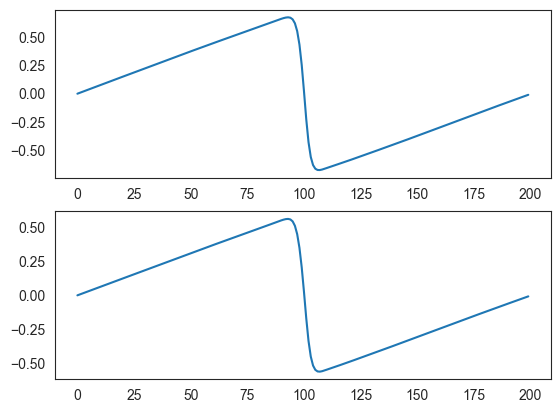

In [39]:
plt.subplot(2, 1, 1)
plt.plot(y_pred[:, 0])
plt.subplot(2,1,2)
plt.plot(y_pred[:, 30])


In [8]:
### Analyzing above case
X = torch.arange(-1, 1 + 0.1, 0.1)
t = torch.arange(-1, 1 + 0.1, 0.1)
print(X)
print(t)

tensor([-1.0000e+00, -9.0000e-01, -8.0000e-01, -7.0000e-01, -6.0000e-01,
        -5.0000e-01, -4.0000e-01, -3.0000e-01, -2.0000e-01, -1.0000e-01,
        -2.9802e-09,  1.0000e-01,  2.0000e-01,  3.0000e-01,  4.0000e-01,
         5.0000e-01,  6.0000e-01,  7.0000e-01,  8.0000e-01,  9.0000e-01,
         1.0000e+00])
tensor([-1.0000e+00, -9.0000e-01, -8.0000e-01, -7.0000e-01, -6.0000e-01,
        -5.0000e-01, -4.0000e-01, -3.0000e-01, -2.0000e-01, -1.0000e-01,
        -2.9802e-09,  1.0000e-01,  2.0000e-01,  3.0000e-01,  4.0000e-01,
         5.0000e-01,  6.0000e-01,  7.0000e-01,  8.0000e-01,  9.0000e-01,
         1.0000e+00])


In [24]:
X= torch.tensor([1,2,3])
y= torch.tensor([4,5,6])

#
#Observe the element-wise pairings across the grid, (1, 4),
#(1, 5), ..., (3, 6). This is the same thing as the
#cartesian product.
grid_x, grid_y = torch.meshgrid(X, y, indexing= 'ij')
print(grid_x, grid_y)

print(torch.stack(torch.meshgrid(X, y)).reshape(2, -1))

tensor([[1, 1, 1],
        [2, 2, 2],
        [3, 3, 3]]) tensor([[4, 5, 6],
        [4, 5, 6],
        [4, 5, 6]])
tensor([[1, 1, 1, 2, 2, 2, 3, 3, 3],
        [4, 5, 6, 4, 5, 6, 4, 5, 6]])


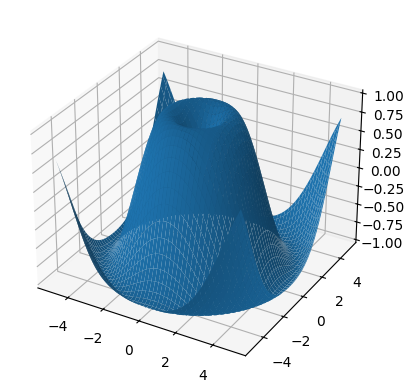

In [21]:
xs = torch.linspace(-5, 5, steps=100)
ys = torch.linspace(-5, 5, steps=100)
x, y = torch.meshgrid(xs, ys, indexing='xy')
z = torch.sin(torch.sqrt(x * x + y * y))
ax = plt.axes(projection='3d')
ax.plot_surface(x.numpy(), y.numpy(), z.numpy())
plt.show()